<a href="https://colab.research.google.com/github/SupriaBasak99/Multi-intent-classification-in-chatbots/blob/main/just_in.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer#ip
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, SimpleRNN, GRU
from keras.callbacks import ModelCheckpoint

In [ ]:
from sklearn.model_selection import train_test_split
#from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [ ]:
def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", names = ["Intent", "Sentence"])
  print(df.head())
  intent = df["Intent"]
  unique_intent = list(set(intent))
  sentences = list(df["Sentence"])
  
  return (intent, unique_intent, sentences)

In [ ]:
intent, unique_intent, sentences = load_dataset("/content/atis_intents_train.csv")

             Intent                                           Sentence
0       atis_flight                                             tokens
1       atis_flight   what flights are available from pittsburgh to...
2  atis_flight_time   what is the arrival time in san francisco for...
3      atis_airfare            cheapest airfare from tacoma to orlando
4      atis_airfare   round trip fares from pittsburgh to philadelp...


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    #stemming
    words.append([i.lower() for i in w])
    
  return words 

In [ ]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[1])  

4834
['what', 'flights', 'are', 'available', 'from', 'pittsburgh', 'to', 'baltimore', 'on', 'thursday', 'morning']


In [ ]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [ ]:
def max_length(words):
  return(len(max(words, key = len)))

In [ ]:
word_tokenizer = create_tokenizer(cleaned_words)
word_index=word_tokenizer.word_index
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 862 and Maximum length = 48


In [ ]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [ ]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [ ]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)

In [ ]:
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [ ]:
output_tokenizer.word_index

{'atis_abbreviation': 6,
 'atis_aircraft': 4,
 'atis_airfare': 8,
 'atis_airline': 5,
 'atis_flight': 7,
 'atis_flight_time': 2,
 'atis_ground_service': 9,
 'atis_quantity': 3,
 'intent': 1}

In [ ]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [ ]:
encoded_output[:5]

array([[1],
       [7],
       [2],
       [8],
       [8]])

In [ ]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [ ]:
output_one_hot = one_hot(encoded_output)

In [ ]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (3867, 48) and train_Y = (3867, 9)
Shape of val_X = (967, 48) and val_Y = (967, 9)


In [ ]:
from keras.initializers import Constant
def create_model_bilstm(vocab_size, max_length):
  model = Sequential()
  #model.add(Embedding(vocab_size, embedded_dim, embeddings_initializer=Constant(embedded_matrix),input_length = max_length, trainable = False))
  #model.add(Embedding(vocab_size, embedded_dim, input_length = max_length, weights=[embedding_matrix],trainable = False))
  model.add(Embedding(vocab_size, 128,input_length = max_length, trainable = True))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(9, activation = "softmax"))  
  return model

In [ ]:
import tensorflow as tf
tf.keras.layers.Embedding

In [ ]:
def create_model_gru(vocab_size, max_length):
  model = Sequential()
  #model.add(Embedding(vocab_size, embedded_dim,embeddings_initializer=Constant(embedded_matrix), input_length = max_length, trainable = False))
  model.add(Embedding(vocab_size, 128,input_length = max_length, trainable = True))
  model.add(GRU(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(9, activation = "softmax"))
  
  return model

In [ ]:
model = create_model_gru(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 48, 128)           110336    
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 9)                 297       
                                                                 
Total params: 213,833
Trainable params: 213,833
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
31/31 [==============================] - ETA: 0s - loss: 1.5427 - accuracy: 0.7065
Epoch 1: val_loss improved from inf to 1.03873, saving model to model.h5
31/31 [==============================] - 12s 212ms/step - loss: 1.5427 - accuracy: 0.7065 - val_loss: 1.0387 - val_accuracy: 0.7797
Epoch 2/5
31/31 [==============================] - ETA: 0s - loss: 1.2084 - accuracy: 0.7448
Epoch 2: val_loss improved from 1.03873 to 0.94433, saving model to model.h5
31/31 [==============================] - 5s 160ms/step - loss: 1.2084 - accuracy: 0.7448 - val_loss: 0.9443 - val_accuracy: 0.7797
Epoch 3/5
31/31 [==============================] - ETA: 0s - loss: 1.1694 - accuracy: 0.7484
Epoch 3: val_loss did not improve from 0.94433
31/31 [==============================] - 5s 157ms/step - loss: 1.1694 - accuracy: 0.7484 - val_loss: 0.9482 - val_accuracy: 0.7797
Epoch 4/5
31/31 [==============================] - ETA: 0s - loss: 1.1340 - accuracy: 0.7499
Epoch 4: val_loss improved from 0.944

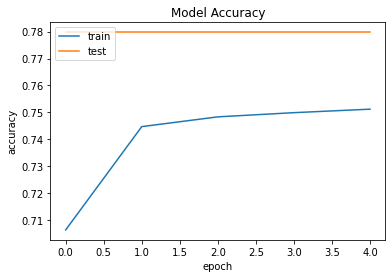

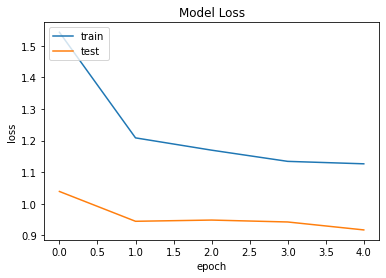

In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(train_X, train_Y, epochs = 5, batch_size = 128, validation_data = (val_X, val_Y), callbacks = [checkpoint])
print(history.history.keys())

# summarize history for accuracy
model_name = "lstm"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(model_name + '_accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(model_name + '_loss.png')
plt.show()

In [ ]:
preds = model.predict(val_X)

score = accuracy_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1))
print("Accuracy: ", score)
f1 = f1_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1), average='macro')
print("Macro F1 Score:", f1)
f1 = f1_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1), average='micro')
print("Micro F1 Score:", f1)
f1 = f1_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1), average='weighted')
print("Weighted F1 Score:", f1, "\n")
# precis = precision_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1),average= 'weighted')
# print("Precision:", precis)
# recal = recall_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1),average='weighted')
# print("Recall:", recal, "\n")

Accuracy:  0.7797311271975181
Macro F1 Score: 0.10952934340499709
Micro F1 Score: 0.7797311271975181
Weighted F1 Score: 0.6832275071550595 

